# 建立 data 数据集

- 数据来源：https://www.kaggle.com/datasets/crailtap/taxi-trajectory

In [126]:
# 手动定义网格的左上角和右下角坐标

# TOPLEFT_LON = -8.699112
# TOPLEFT_LAT = 41.263356
# BOTTOMRIGHT_LON = -8.537064
# BOTTOMRIGHT_LAT = 41.115314

TOPLEFT_LON = -8.701859
TOPLEFT_LAT = 41.200615
BOTTOMRIGHT_LON = -8.543243
BOTTOMRIGHT_LAT = 41.124366

# TOPLEFT_LON = -8.694837
# TOPLEFT_LAT = 41.190156
# BOTTOMRIGHT_LON = -8.556534
# BOTTOMRIGHT_LAT = 41.137272

grid_size_km = 0.5  # 网格的边长(km)


## 1. 读取数据与预处理


In [ ]:
import pandas as pd
import numpy as np
import ast

# 读取数据
df = pd.read_csv('train.csv')
df = df[['TIMESTAMP', 'MISSING_DATA', 'POLYLINE']]

# 时间特征提取
df['DATETIME'] = pd.to_datetime(df['TIMESTAMP'], unit='s')
df['DATE'] = df['DATETIME'].dt.strftime('%Y-%m-%d')
df['HOUR'] = df['DATETIME'].dt.hour
df['WEEKDAY'] = df['DATETIME'].dt.weekday  # 0-6 表示周一到周日

df.head()


,TIMESTAMP,MISSING_DATA,POLYLINE,DATETIME,DATE,HOUR,WEEKDAY
0,1372636858,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",2013-07-01 00:00:58,2013-07-01,0,0
1,1372637303,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",2013-07-01 00:08:23,2013-07-01,0,0
2,1372636951,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",2013-07-01 00:02:31,2013-07-01,0,0
3,1372636854,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",2013-07-01 00:00:54,2013-07-01,0,0
4,1372637091,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",2013-07-01 00:04:51,2013-07-01,0,0


In [ ]:
# 使用前60000条数据
df = df[:60000]

print(f"数据范围: {df['DATETIME'].min()} ~ {df['DATETIME'].max()}")
print(f"总轨迹数: {len(df)}")

数据范围: 2013-07-01 00:00:53 ~ 2013-07-13 03:18:10
总轨迹数: 60000


- 过滤MISSING_DATA==True的行；过滤掉轨迹点数小于阈值的数据


In [129]:
df = df[df['MISSING_DATA'] == False]  # 只保留无缺失值的行

# 设置轨迹点数阈值
MIN_PORINTS = 5

# 过滤掉轨迹点数小于阈值的数据
def valid_polyline(polyline_str):
    try:
        coords = ast.literal_eval(polyline_str)
        if coords and len(coords) >= MIN_PORINTS:
            return True
    except:
        pass
    return False

print(f"原始轨迹数: {len(df)}")
df = df[df['POLYLINE'].apply(valid_polyline)]
print(f"有效轨迹数: {len(df)}")

原始轨迹数: 60000
有效轨迹数: 58533


## 2. 提取起点和终点坐标


In [130]:
# 解析轨迹，提取起点和终点
def extract_endpoints(polyline_str):
    """从POLYLINE字符串提取起点和终点"""
    coords = ast.literal_eval(polyline_str)
    if coords and len(coords) > 0:
        return coords[0], coords[-1]  # [经度, 纬度]

# 提取起点和终点
df[['START_POINT', 'END_POINT']] = df['POLYLINE'].apply(
    lambda x: pd.Series(extract_endpoints(x))
)


- 在地图上可视化

In [131]:
import folium

# 计算起点和终点经纬度的均值，用于初始化地图中心
start_lons = df['START_POINT'].apply(lambda x: x[0])
start_lats = df['START_POINT'].apply(lambda x: x[1])
end_lons = df['END_POINT'].apply(lambda x: x[0])
end_lats = df['END_POINT'].apply(lambda x: x[1])

center_lat = np.mean(np.concatenate([start_lats, end_lats]))
center_lon = np.mean(np.concatenate([start_lons, end_lons]))

# 创建folium地图
m = folium.Map(location=[center_lat, center_lon], zoom_start=12, tiles='cartodbpositron')

# 添加图例，说明蓝色代表起点，红色代表终点
legend_html = '''
     <div style="
         position: fixed; 
         bottom: 50px; left: 50px; width: 160px; height: 80px; 
         background-color: white; 
         border:2px solid grey; 
         z-index:9999; 
         font-size:14px;
         box-shadow: 2px 2px 6px rgba(0,0,0,0.2);
         padding: 8px 12px;
         ">
     <b>图例：</b><br>
     <span style="color:blue; font-weight:bold;">●</span> 起点<br>
     <span style="color:red; font-weight:bold;">●</span> 终点
     </div>
'''
m.get_root().html.add_child(folium.Element(legend_html))
# 只画一部分轨迹点以提升速度
N = min(3000, len(df))
for idx, row in df.iloc[:N].iterrows():
    # 起点
    folium.CircleMarker(
        location=row['START_POINT'][::-1],  # folium: [lat, lon]
        radius=2,
        color='blue',
        fill=True,
        fill_opacity=0.5,
        popup=f"Start {idx}<br>({row['START_POINT'][0]:.6f}, {row['START_POINT'][1]:.6f})"
    ).add_to(m)
    # 终点
    folium.CircleMarker(
        location=row['END_POINT'][::-1],
        radius=2,
        color='red',
        fill=True,
        fill_opacity=0.5,
        popup=f"End {idx}<br>({row['END_POINT'][0]:.6f}, {row['END_POINT'][1]:.6f})"
    ).add_to(m)

from folium import MacroElement
from jinja2 import Template

class ClickForLatLon(MacroElement):
    _template = Template(u"""
        {% macro script(this, kwargs) %}
        {{this._parent.get_name()}}.on('click', function(e) {
            var lat = e.latlng.lat.toFixed(6);
            var lng = e.latlng.lng.toFixed(6);
            L.popup()
                .setLatLng(e.latlng)
                .setContent("您点击的位置经纬度:<br />" + lng + ", " + lat)
                .openOn({{this._parent.get_name()}});
        });
        {% endmacro %}
    """)
m.add_child(ClickForLatLon())

# 保存
m.save('html/start&end_points.html')
print("已保存为 html/start&end_points.html")

已保存为 html/start&end_points.html


## 3. 创建空间网格


In [132]:

# TOPLEFT_LON
# TOPLEFT_LAT
# BOTTOMRIGHT_LON
# BOTTOMRIGHT_LAT

print(f"\n==== 网格坐标范围 ====")
print(f"  网格左上角 (经度, 纬度): ({TOPLEFT_LON}, {TOPLEFT_LAT})")
print(f"  网格右下角 (经度, 纬度): ({BOTTOMRIGHT_LON}, {BOTTOMRIGHT_LAT})")

# # 网格参数
# grid_size_km  # 网格的边长(km)

# 计算经纬度范围（单位：度）
lat_range = TOPLEFT_LAT - BOTTOMRIGHT_LAT  # 纬度差（北纬大于南纬）
lon_range = BOTTOMRIGHT_LON - TOPLEFT_LON  # 经度差（东经大于西经）

print(f"\n==== 坐标范围 ====")
print(f"  纬度范围: {lat_range:.6f}度")
print(f"  经度范围: {lon_range:.6f}度")

# 计算实际距离（单位：千米）
lat_range_km = lat_range * 111  # 1度纬度 ≈ 111千米
lon_range_km = lon_range * 111 * np.cos(np.radians((TOPLEFT_LAT + BOTTOMRIGHT_LAT) / 2))

print(f"\n==== 实际距离 ====")
print(f"  南北距离: {lat_range_km:.2f} km")
print(f"  东西距离: {lon_range_km:.2f} km")

# 计算网格数量（向下取整，边缘无法整除的省略）
grid_rows = int(lat_range_km / grid_size_km)
grid_cols = int(lon_range_km / grid_size_km)

# 计算实际使用的经纬度步长
lat_step = lat_range / grid_rows
lon_step = lon_range / grid_cols

print(f"\n==== 网格步长 ====")
print(f"  纬度步长: {lat_step:.6f}度/格")
print(f"  经度步长: {lon_step:.6f}度/格")

# 保存网格参数
grid_params = {
    'topleft_lon': TOPLEFT_LON,
    'topleft_lat': TOPLEFT_LAT,
    'bottomright_lon': BOTTOMRIGHT_LON,
    'bottomright_lat': BOTTOMRIGHT_LAT,
    'grid_rows': grid_rows,
    'grid_cols': grid_cols,
    'lat_step': lat_step,
    'lon_step': lon_step
}

print(f"\n✅ 网格参数设置完成:")
print(f"  网格大小: {grid_size_km}km * {grid_size_km}km")
print(f"  网格维度: {grid_rows}行 * {grid_cols}列")



==== 网格坐标范围 ====
  网格左上角 (经度, 纬度): (-8.701859, 41.200615)
  网格右下角 (经度, 纬度): (-8.543243, 41.124366)

==== 坐标范围 ====
  纬度范围: 0.076249度
  经度范围: 0.158616度

==== 实际距离 ====
  南北距离: 8.46 km
  东西距离: 13.25 km

==== 网格步长 ====
  纬度步长: 0.004766度/格
  经度步长: 0.006101度/格

✅ 网格参数设置完成:
  网格大小: 0.5km * 0.5km
  网格维度: 16行 * 26列


## 4. 生成数据张量 data

- 获取覆盖所有点的网格

In [133]:
def coord_to_grid(lon, lat):
    """
    将经纬度转换为网格索引
    网格从左上角(0, 0)开始，向右下扩展
    """
    # 检查是否在网格范围内
    if not (grid_params['topleft_lon'] <= lon <= grid_params['bottomright_lon'] and
            grid_params['bottomright_lat'] <= lat <= grid_params['topleft_lat']):
        return None
    
    # 计算相对于左上角的偏移
    lon_offset = lon - grid_params['topleft_lon']
    lat_offset = grid_params['topleft_lat'] - lat  # 纬度从上到下递减
    
    # 转换为网格索引（向下取整）
    col = int(lon_offset / grid_params['lon_step'])
    row = int(lat_offset / grid_params['lat_step'])
    
    # 边界检查（确保不超出网格范围）
    if 0 <= row < grid_rows and 0 <= col < grid_cols:
        return row, col
    return None

# 按 (日期, 小时) 分组
time_groups = df.groupby(['DATE', 'HOUR'])
total_timesteps = len(time_groups)

print(f"\n==== 时间分组 ====")
print(f"  总时段数: {total_timesteps}")

# 初始化数据: (Total_Timesteps, 3, Grid_Rows, Grid_Cols)
data = np.zeros((total_timesteps, 3, grid_rows, grid_cols), dtype=float)

# 统计落在网格内的点数
total_points = 0
valid_points = 0

# 为每个时段统计流量
for idx, ((date, hour), group) in enumerate(time_groups):
    # 通道0: 流出量（起点）
    for start_point in group['START_POINT']:
        total_points += 1
        grid_idx = coord_to_grid(start_point[0], start_point[1])
        if grid_idx:
            valid_points += 1
            row, col = grid_idx
            data[idx, 0, row, col] += 1
    
    # 通道1: 流入量（终点）
    for end_point in group['END_POINT']:
        total_points += 1
        grid_idx = coord_to_grid(end_point[0], end_point[1])
        if grid_idx:
            valid_points += 1
            row, col = grid_idx
            data[idx, 1, row, col] += 1
    
    # 通道2: IS_WEEKEND（周六=5, 周日=6）
    weekday = group.iloc[0]['WEEKDAY']
    is_weekend = 1 if weekday >= 5 else 0
    data[idx, 2, :, :] = is_weekend

print(f"\n==== 数据统计 ====")
print(f"  总点数: {total_points}")
print(f"  落在网格内的点数: {valid_points}")
print(f"  覆盖率: {valid_points/total_points*100:.2f}%")

print(f"\n==== 生成的数据形状 ====")
print(f"  (时段数, 通道数, 网格行数, 网格列数) = ({total_timesteps}, 3, {grid_rows}, {grid_cols})")
print(f"\n✅ data 生成完成!")


==== 时间分组 ====
  总时段数: 292

==== 数据统计 ====
  总点数: 117066
  落在网格内的点数: 110247
  覆盖率: 94.18%

==== 生成的数据形状 ====
  (时段数, 通道数, 网格行数, 网格列数) = (292, 3, 16, 26)

✅ data 生成完成!


- 可视化各个网格的流入流出量

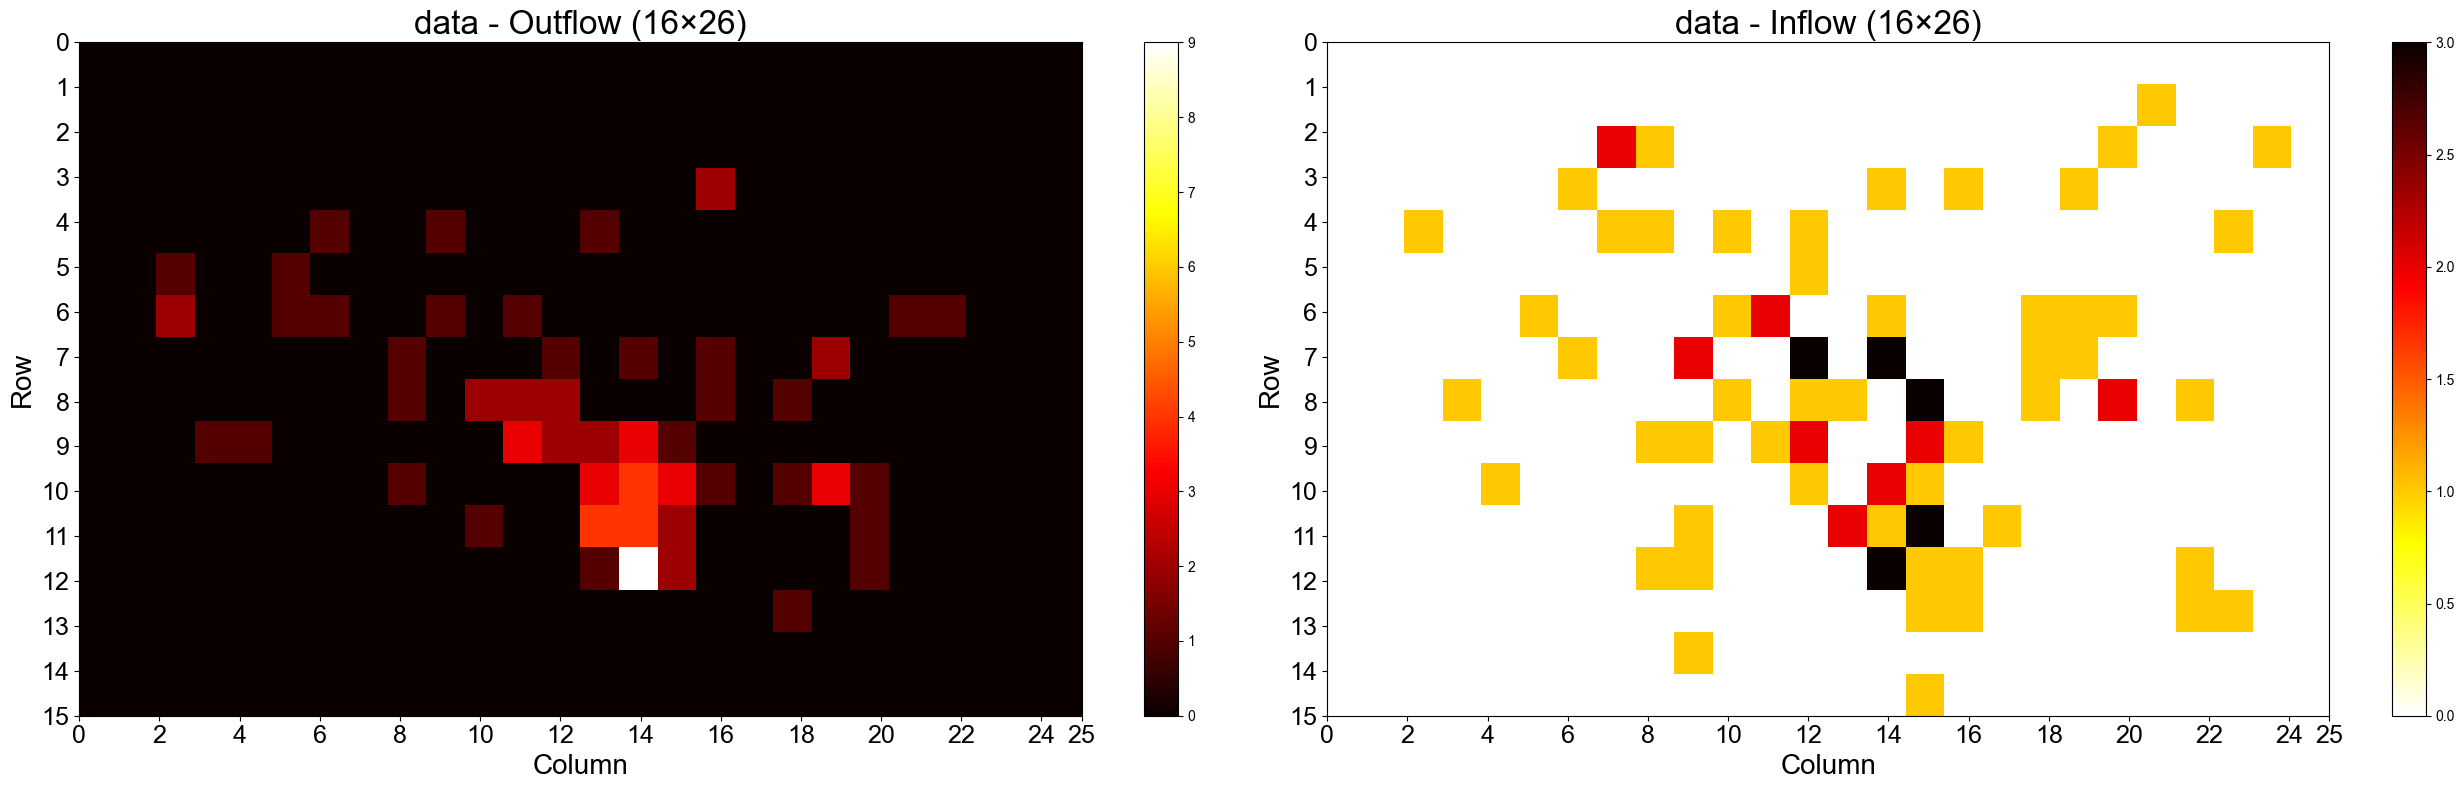

网格数量: 16 * 26


In [134]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(grid_cols, grid_rows // 2))

timestep = 0 

OPT_SHAPE = f"{data.shape[2]}×{data.shape[3]}"
extent = [0, data.shape[3] - 1, data.shape[2] - 1, 0]  # 坐标从0开始

for col_idx, ch in enumerate([0, 1]):
    axs = axes[col_idx]
    cmap = 'hot_r' if ch == 1 else 'hot'
    im = axs.imshow(
        data[timestep, ch], 
        cmap=cmap, 
        aspect='auto', 
        extent=extent
    )
    ch_name = 'Inflow' if ch == 1 else 'Outflow'
    axs.set_title(f"data - {ch_name} ({OPT_SHAPE})", fontsize=24)
    axs.set_xlabel('Column', fontsize=20)
    axs.set_ylabel('Row', fontsize=20)
    col_ticks = list(range(0, data.shape[3], max(1, data.shape[3] // 10)))
    row_ticks = list(range(0, data.shape[2], max(1, data.shape[2] // 10)))
    if data.shape[3] - 1 not in col_ticks:
        col_ticks.append(data.shape[3] - 1)
    if data.shape[2] - 1 not in row_ticks:
        row_ticks.append(data.shape[2] - 1)
    axs.set_xticks(col_ticks)
    axs.set_yticks(row_ticks)
    axs.tick_params(axis='both', which='major', labelsize=18)
    plt.colorbar(im, ax=axs)

plt.tight_layout()
plt.show()

grid_rows, grid_cols = data.shape[2], data.shape[3]
print(f"网格数量: {grid_rows} * {grid_cols}")


## 5. CNN-LSTM模型训练


### 5.1. 数据归一化与创建时间序列


In [135]:
# ------- 数据归一化 -------
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# ------ 创建时间序列数据（CNN-LSTM版本：保持空间结构）-------
def create_sequences_cnnlstm(data, seq_length=12):
    """
    创建CNN-LSTM所需的时间序列数据集（保持空间结构）
    Args:
        data: (Total_Timesteps, 3, Grid_Rows, Grid_Cols)
        seq_length: 输入序列长度
    Returns:
        X: (N, seq_length, 3, Grid_Rows, Grid_Cols) 输入序列
        y: (N, 2, Grid_Rows, Grid_Cols) 目标（只预测流出量和流入量）
    """
    N, C, grid_rows, grid_cols = data.shape
    X, y = [], []
    for i in range(N - seq_length):
        # 输入：前seq_length个时段的所有通道，保持空间结构
        X.append(data[i:i+seq_length])  # (seq_length, 3, Grid_Rows, Grid_Cols)
        # 目标：下一个时段的流出量和流入量（只取通道0,1）
        y.append(data[i+seq_length, :2])  # (2, Grid_Rows, Grid_Cols)
    return np.array(X), np.array(y)

# 先创建序列数据（使用原始data，未归一化）
seq_length = 12  # 使用过去12个时段预测下一个时段
X, y = create_sequences_cnnlstm(data, seq_length)

print(f"输入形状 X: {X.shape}")  # (N, seq_length, 3, Grid_Rows, Grid_Cols)
print(f"目标形状 y: {y.shape}")  # (N, 2, Grid_Rows, Grid_Cols)

# 划分训练集和测试集（80/20）
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"\n训练集: X_train = {X_train.shape}, y_train = {y_train.shape}")
print(f"测试集: X_test = {X_test.shape}, y_test = {y_test.shape}")

# ------- 数据归一化（修复数据泄露：只在训练集上fit scaler）-------
# 创建归一化器（分别对流出和流入做MinMax归一化，只处理第0/1通道）
scaler_out = MinMaxScaler()
scaler_in = MinMaxScaler()

# 计算训练集对应的原始数据索引范围
# X_train中的样本i对应原始数据中的时段范围 [i, i+seq_length]
# 所以训练集用到的原始数据时段范围是 [0, split_idx+seq_length]
train_data_end_idx = split_idx + seq_length

# 只在训练集对应的原始数据上fit scaler
train_data_out = data[:train_data_end_idx, 0, :, :].reshape(-1, 1)
train_data_in = data[:train_data_end_idx, 1, :, :].reshape(-1, 1)

scaler_out.fit(train_data_out)
scaler_in.fit(train_data_in)

# 对整个data进行transform（用于后续预测）
shape = data.shape
out_flat = data[:, 0, :, :].reshape(-1, 1)
in_flat = data[:, 1, :, :].reshape(-1, 1)

out_norm = scaler_out.transform(out_flat).reshape(shape[0], shape[2], shape[3])
in_norm = scaler_in.transform(in_flat).reshape(shape[0], shape[2], shape[3])

data_norm = data.copy()
data_norm[:, 0, :, :] = out_norm
data_norm[:, 1, :, :] = in_norm
# 通道2（如周末/节假日标记）不做归一化

print(f"\n数据归一化完成（只在训练集上fit scaler）")

# 替换data为归一化后的data_norm
data = data_norm

# 使用归一化后的data重新创建序列
X, y = create_sequences_cnnlstm(data, seq_length)

# 重新划分训练集和测试集
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"\n归一化后重新创建序列:")
print(f"训练集: X_train = {X_train.shape}, y_train = {y_train.shape}")
print(f"测试集: X_test = {X_test.shape}, y_test = {y_test.shape}")


输入形状 X: (280, 12, 3, 16, 26)
目标形状 y: (280, 2, 16, 26)

训练集: X_train = (224, 12, 3, 16, 26), y_train = (224, 2, 16, 26)
测试集: X_test = (56, 12, 3, 16, 26), y_test = (56, 2, 16, 26)

数据归一化完成（只在训练集上fit scaler）

归一化后重新创建序列:
训练集: X_train = (224, 12, 3, 16, 26), y_train = (224, 2, 16, 26)
测试集: X_test = (56, 12, 3, 16, 26), y_test = (56, 2, 16, 26)


### 5.2. 准备DataLoader


In [136]:
# 转换为PyTorch张量 & 构造DataLoader（不要shuffle！）
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

batch_size = 4
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# 保持shuffle=False，不能打乱时序
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"训练批次数: {len(train_loader)}")
print(f"测试批次数: {len(test_loader)}")


训练批次数: 56
测试批次数: 14


### 5.3. 构建CNN-LSTM模型


In [137]:
# 定义CNN-LSTM模型 - 结合空间和时间特征
class CNNLSTM(nn.Module):
    """
    CNN-LSTM混合模型：先用CNN提取空间特征，再用LSTM处理时间序列
    """
    def __init__(self, channels=3, grid_rows=grid_rows, grid_cols=grid_cols, 
                 cnn_filters=32, lstm_hidden=64, lstm_layers=2, dropout=0.5):
        super(CNNLSTM, self).__init__()
        self.grid_rows = grid_rows
        self.grid_cols = grid_cols
        
        # CNN层：提取空间特征
        self.conv1 = nn.Conv2d(channels, cnn_filters, kernel_size=3, padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(cnn_filters)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout2d(dropout)  # 添加Dropout正则化
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(cnn_filters, cnn_filters*2, kernel_size=3, padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(cnn_filters*2)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout2d(dropout)  # 添加Dropout正则化
        
        # 计算CNN输出的特征维度
        # 经过两次池化后：height = grid_rows // 4, width = grid_cols // 4
        cnn_output_h = grid_rows // 4
        cnn_output_w = grid_cols // 4
        cnn_output_dim = cnn_filters * 2 * cnn_output_h * cnn_output_w
        
        # LSTM层
        self.lstm = nn.LSTM(
            input_size=cnn_output_dim,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            dropout=dropout if lstm_layers > 1 else 0  # LSTM层间dropout
        )
        
        # 全连接层前添加Dropout
        self.dropout_fc = nn.Dropout(dropout)
        self.fc = nn.Linear(lstm_hidden, 2 * grid_rows * grid_cols)
        
    def forward(self, x):
        # x: (batch, seq_len, channels, height, width)
        batch_size, seq_len = x.size(0), x.size(1)
        
        # 初始化列表用于保存每个时间步的CNN输出
        cnn_outputs = []
        # 循环处理每个时间步
        for t in range(seq_len):
            # 取出第t个时间步的空间特征 (batch, channels, height, width)
            xt = x[:, t, :, :, :]
            # 通过第一个卷积层
            out = self.conv1(xt)
            out = self.bn1(out)
            out = self.relu(out)
            out = self.dropout1(out)
            out = self.pool1(out)
            # 通过第二个卷积层
            out = self.conv2(out)
            out = self.bn2(out)
            out = self.relu(out)
            out = self.dropout2(out)
            out = self.pool2(out)
            # 展平成向量
            out = out.view(batch_size, -1)
            # 保存该时间步的特征
            cnn_outputs.append(out)
        
        # 堆叠成LSTM输入: (batch, seq_len, cnn_output_dim)
        lstm_input = torch.stack(cnn_outputs, dim=1)
        
        # LSTM处理
        lstm_out, _ = self.lstm(lstm_input)
        last_output = lstm_out[:, -1, :]  # 取最后时间步
        
        # 全连接层（添加Dropout正则化）
        last_output = self.dropout_fc(last_output)
        output = self.fc(last_output)
        output = output.view(batch_size, 2, self.grid_rows, self.grid_cols)
        return output

# 初始化模型
device = torch.device('cpu')
channels = X_train.shape[2]
grid_rows, grid_cols = data.shape[2], data.shape[3]

# 设置正则化参数
dropout_rate = 0.2  # Dropout比率

model = CNNLSTM(
    channels=channels, 
    grid_rows=grid_rows,
    grid_cols=grid_cols,
    cnn_filters=32,
    lstm_hidden=64,
    lstm_layers=2,
    dropout=dropout_rate  # 添加Dropout正则化
).to(device)

print(f"✅ 模型初始化完成（CNN-LSTM）")
print(f"使用设备: {device}")
print(f"模型参数量: {sum(p.numel() for p in model.parameters()):,}")
print(f"网格大小: {grid_rows} × {grid_cols}")


✅ 模型初始化完成（CNN-LSTM）
使用设备: cpu
模型参数量: 517,056
网格大小: 16 × 26


### 5.4. 训练模型


In [138]:
# 定义损失函数和优化器
criterion = nn.MSELoss()

# 添加L2正则化（weight_decay）
weight_decay = 1e-5  # L2正则化系数
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay)

# 添加学习率下降策略（按验证集loss不下降调整）
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True, min_lr=1e-5)

# 训练函数（CNN-LSTM版本：y已经是正确形状）
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for batch_X, batch_y in loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        
        # y已经是(batch, 2, grid_rows, grid_cols)形状，无需调整
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    return total_loss / len(loader)

# 评估函数（CNN-LSTM版本）
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)            
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            total_loss += loss.item()
    
    return total_loss / len(loader)

# 训练循环 - 加入早停和学习率下降策略
num_epochs = 50
patience = 10 # 早停耐心参数, 即当测试集损失连续 10 轮未显著下降（差值<1e-6）时, 触发早停
best_test_loss = float('inf')
epochs_no_improve = 0
early_stop = False
train_losses = []
test_losses = []
best_model_wts = None

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    test_loss = evaluate(model, test_loader, criterion, device)

    # 学习率衰减策略
    scheduler.step(test_loss)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch [{epoch+1}/{num_epochs}] - 训练损失: {train_loss:.6f}, 测试损失: {test_loss:.6f} | 当前学习率: {current_lr:.6f}")
    
    # 早停判断
    if test_loss < best_test_loss - 1e-6:
        best_test_loss = test_loss
        epochs_no_improve = 0
        # 保存最佳模型参数
        best_model_wts = model.state_dict()
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"\n==== 早停：验证集损失连续 {patience} 轮未提升 ====")
            early_stop = True
            break

# 恢复最佳模型权重（如果发生早停，否则就是最后一轮权重）
if best_model_wts is not None:
    model.load_state_dict(best_model_wts)

if early_stop:
    print("\n==== 训练早停 ====")
else:
    print("\n==== 训练完成 ====")
print(f"最终训练损失: {train_losses[-1]:.6f}")
print(f"最终测试损失: {test_losses[-1]:.6f}")


/Users/yangyuntian/Desktop/My doc/华东师范大学各类活动与事情/S3/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/50] - 训练损失: 0.002400, 测试损失: 0.000309 | 当前学习率: 0.001000
Epoch [2/50] - 训练损失: 0.000441, 测试损失: 0.000234 | 当前学习率: 0.001000
Epoch [3/50] - 训练损失: 0.000354, 测试损失: 0.000221 | 当前学习率: 0.001000
Epoch [4/50] - 训练损失: 0.000306, 测试损失: 0.000222 | 当前学习率: 0.001000
Epoch [5/50] - 训练损失: 0.000283, 测试损失: 0.000215 | 当前学习率: 0.001000
Epoch [6/50] - 训练损失: 0.000266, 测试损失: 0.000221 | 当前学习率: 0.001000
Epoch [7/50] - 训练损失: 0.000252, 测试损失: 0.000206 | 当前学习率: 0.001000
Epoch [8/50] - 训练损失: 0.000242, 测试损失: 0.000197 | 当前学习率: 0.001000
Epoch [9/50] - 训练损失: 0.000233, 测试损失: 0.000194 | 当前学习率: 0.001000
Epoch [10/50] - 训练损失: 0.000228, 测试损失: 0.000185 | 当前学习率: 0.001000
Epoch [11/50] - 训练损失: 0.000215, 测试损失: 0.000180 | 当前学习率: 0.001000
Epoch [12/50] - 训练损失: 0.000212, 测试损失: 0.000174 | 当前学习率: 0.001000
Epoch [13/50] - 训练损失: 0.000213, 测试损失: 0.000179 | 当前学习率: 0.001000
Epoch [14/50] - 训练损失: 0.000207, 测试损失: 0.000175 | 当前学习率: 0.001000
Epoch [15/50] - 训练损失: 0.000205, 测试损失: 0.000170 | 当前学习率: 0.001000
Epoch [16/50] - 训练损失: 0.000201, 测试

### 5.5. 可视化loss


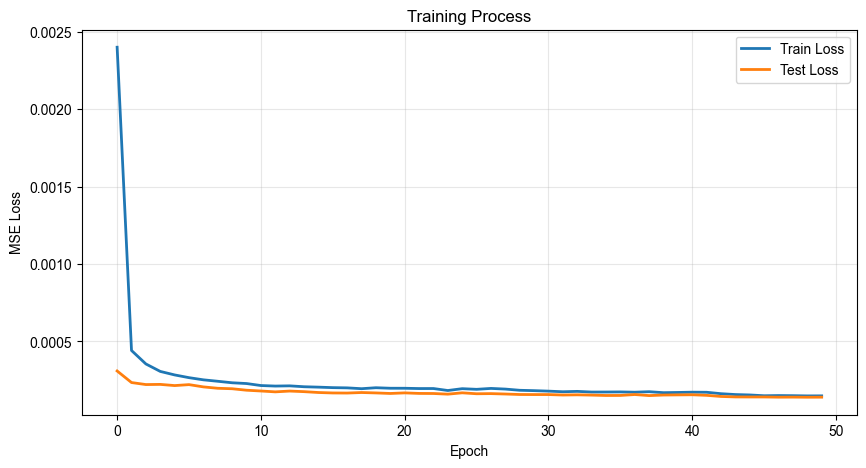

In [139]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(test_losses, label='Test Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Process')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



### 5.6. 保存模型


In [140]:
# 保存CNN-LSTM模型（包含所有必要参数）
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'test_losses': test_losses,
    # 保存CNN-LSTM模型结构参数
    'channels': channels,
    'grid_rows': grid_rows,
    'grid_cols': grid_cols,
    'cnn_filters': 32,
    'lstm_hidden': 64,
    'lstm_layers': 2,
}, 'model/flow_model.pth')

print("✅ CNN-LSTM模型已保存到 flow_model.pth")
print(f"   模型参数: channels = {channels}, grid = {grid_rows} * {grid_cols}")


✅ CNN-LSTM模型已保存到 flow_model.pth
   模型参数: channels = 3, grid = 16 * 26


## 6. 预测

### 6.1. 加载模型

In [141]:
# 加载已保存的CNN-LSTM模型
checkpoint = torch.load('model/flow_model.pth', map_location=device)

# 使用checkpoint中保存的参数初始化CNN-LSTM模型
model_loaded = CNNLSTM(
    channels = checkpoint['channels'],
    grid_rows = checkpoint['grid_rows'],
    grid_cols = checkpoint['grid_cols'],
    cnn_filters = checkpoint['cnn_filters'],
    lstm_hidden = checkpoint['lstm_hidden'],
    lstm_layers = checkpoint['lstm_layers']
).to(device)

# 加载模型权重
model_loaded.load_state_dict(checkpoint['model_state_dict'])
model_loaded.eval()

print("\n✅ CNN-LSTM模型加载成功！")
print(f"   训练损失: {checkpoint['train_losses'][-1]:.4f}")
print(f"   测试损失: {checkpoint['test_losses'][-1]:.4f}")



✅ CNN-LSTM模型加载成功！
   训练损失: 0.0001
   测试损失: 0.0001


/var/folders/4x/vk43ls6s5xdbcnk23qh1bp_00000gn/T/ipykernel_37136/781342067.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('model/flow_model.pth'

### 6.2. 预测下一个时段的流量

In [ ]:
with torch.no_grad():
    # 最后12个时段的数据
    last_12_timesteps = data[-12:]  # (12, 3, 16, 26)
    
    # 转换为模型输入格式：(1, 12, 3, 16, 26)
    input_data = last_12_timesteps[np.newaxis, ...]  # 添加batch维度
    input_tensor = torch.FloatTensor(input_data).to(device)
    
    # 预测（得到归一化后的结果）
    prediction = model_loaded(input_tensor)  # (1, 2, 16, 26)
    
    # 移除batch维度
    flow_prediction = prediction.squeeze(0)  # (2, 16, 26)

# 反归一化：将预测结果转换回原始尺度
outflow_pred = flow_prediction[0].cpu().numpy()  # 流出量预测
inflow_pred = flow_prediction[1].cpu().numpy()  # 流入量预测

# 反归一化流出量
outflow_denorm = scaler_out.inverse_transform(outflow_pred.reshape(-1, 1)).reshape(outflow_pred.shape)
# 反归一化流入量  
inflow_denorm = scaler_in.inverse_transform(inflow_pred.reshape(-1, 1)).reshape(inflow_pred.shape)

# 将负值设置为0
outflow_denorm[(outflow_denorm < 0)] = 0
inflow_denorm[(inflow_denorm < 0)] = 0

# 计算反归一化后的净流量：流入量 - 流出量
net_flow_denorm = inflow_denorm - outflow_denorm

# 打印预测时段的时间
last_datetime = df['DATETIME'].max()  # 获取最后一个时段的时间
if isinstance(last_datetime, str):
    last_datetime = pd.to_datetime(last_datetime)
# 将last_datetime向上取整到下一个整点，得到时间段起始时间
next_period_start = last_datetime.ceil('h')
next_period_end = next_period_start + pd.Timedelta(hours=1)

print("预测结果: \n")
# 净流量矩阵保留整数（反归一化后的真实值）
title_time_str = f"净流量矩阵: {next_period_start} ~ {next_period_end}"

net_flow_int_array = net_flow_denorm.astype(int)
print(title_time_str)
# 创建DataFrame（使用优化后网格的索引）
net_flow_df = pd.DataFrame(
    net_flow_int_array,
    index=[f'Row {i}' for i in range(net_flow_int_array.shape[0])],
    columns=[f'Col {j}' for j in range(net_flow_int_array.shape[1])]
)

display(net_flow_df)
# # 保存
# net_flow_df.to_csv(f'net_flow_prediction_{title_time_str}.csv', encoding='utf-8')
# print(f"净流量预测已保存为 net_flow_prediction_{title_time_str}.csv")

print("\n✅ 预测完成！")


预测结果: 

净流量矩阵: 2013-07-13 04:00:00 ~ 2013-07-13 05:00:00


,Col 0,Col 1,Col 2,Col 3,Col 4,Col 5,Col 6,Col 7,Col 8,Col 9,...,Col 16,Col 17,Col 18,Col 19,Col 20,Col 21,Col 22,Col 23,Col 24,Col 25
Row 0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Row 1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Row 2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Row 3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Row 4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Row 5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Row 6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Row 7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Row 8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Row 9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0



✅ 预测完成！


### 6.3. 可视化预测结果

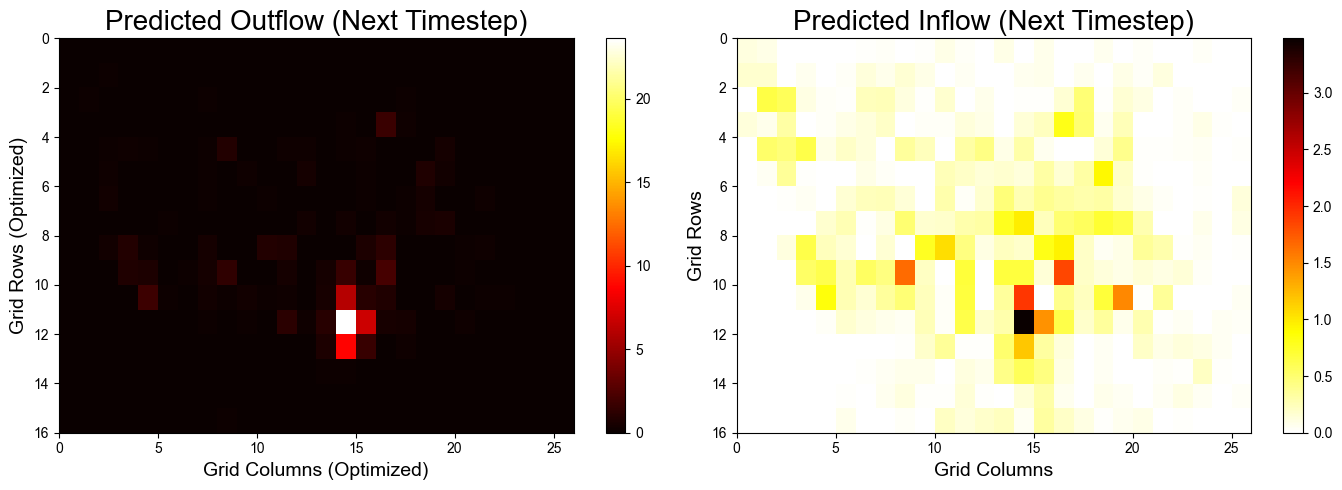

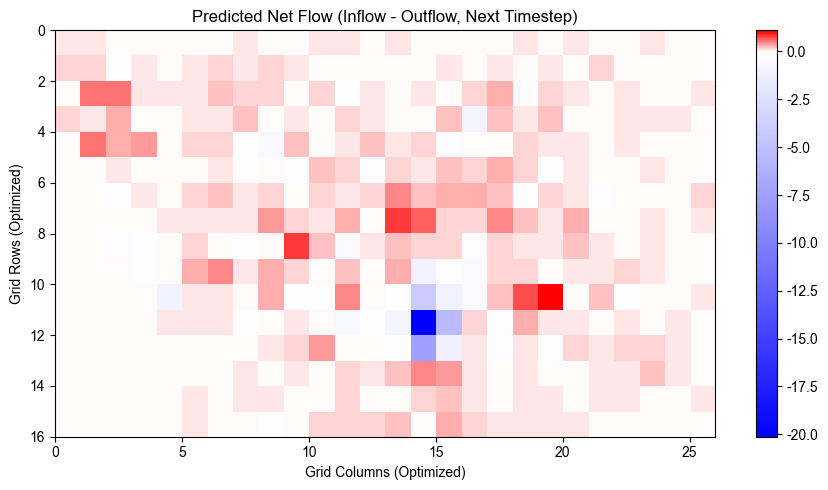

In [ ]:
# 可视化预测结果（流出量、流入量）以及净流量

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

num_rows, num_cols = outflow_denorm.shape[0], outflow_denorm.shape[1]
extent = [0, num_cols, num_rows, 0]

# 使用反归一化后的数据
outflow_array = outflow_denorm
inflow_array = inflow_denorm

# 流出量热力图（左侧）
im1 = axes[0].imshow(
    outflow_array,
    cmap='hot',
    aspect='auto',
    extent=extent,
    origin='upper'
)
axes[0].set_title('Predicted Outflow (Next Timestep)', fontsize=20)
axes[0].set_xlabel('Grid Columns (Optimized)', fontsize=14)
axes[0].set_ylabel('Grid Rows (Optimized)', fontsize=14)
plt.colorbar(im1, ax=axes[0])

# 流入量热力图（右侧）
im2 = axes[1].imshow(
    inflow_array,
    cmap='hot_r',  # hot色系反转
    aspect='auto',
    extent=extent,
    origin='upper'
)
axes[1].set_title('Predicted Inflow (Next Timestep)', fontsize=20)
axes[1].set_xlabel('Grid Columns', fontsize=14)
axes[1].set_ylabel('Grid Rows', fontsize=14)
plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()

# ====== 净流量热力图（0始终为白色, 坐标范围为实际极值）======
import matplotlib.colors as mcolors
fig2, ax3 = plt.subplots(1, 1, figsize=(9, 5))

net_flow_np = net_flow_denorm

vmin = net_flow_np.min()
vmax = net_flow_np.max()

if vmin == 0 and vmax == 0:
    vmin, vmax = -1.0, 1.0

# 用于计算“0为白”对应的位置
def calc_white_pos(vmin, vmax):
    if vmax == vmin:
        return 0.5
    if vmin < 0 < vmax:
        return -vmin / (vmax - vmin)
    elif vmin == 0 and vmax > 0:
        return 0.0
    elif vmin < 0 and vmax == 0:
        return 1.0
    else:
        # 所有数都同号（不应该出现，保险）
        return 0.5

white_pos = calc_white_pos(vmin, vmax)

# 构造蓝-白-红色带，0为白，其它为极值蓝红
cmap = mcolors.LinearSegmentedColormap.from_list(
    'custom_bwr',
    [
        (0.0, 'blue'),      # 最小值 蓝
        (white_pos, 'white'),  # 0处 白色
        (1.0, 'red')       # 最大值 红
    ]
)

# 使用标准Normalize，只设置vmin/vmax
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

im3 = ax3.imshow(
    net_flow_np,
    cmap=cmap,
    aspect='auto',
    extent=extent,
    origin='upper',
    norm=norm
)
ax3.set_title('Predicted Net Flow (Inflow - Outflow, Next Timestep)')
ax3.set_xlabel('Grid Columns (Optimized)')
ax3.set_ylabel('Grid Rows (Optimized)')
plt.colorbar(im3, ax=ax3)

plt.tight_layout()
plt.show()


### 6.4. 在地图上可视化热力图

In [144]:
import folium
import matplotlib.colors as mcolors

# 使用保存的密集区域左上角坐标
topleft_lon = TOPLEFT_LON
topleft_lat = TOPLEFT_LAT

# 获取优化后网格的行列数
num_rows = data.shape[2]  # 优化后的行数
num_cols = data.shape[3]  # 优化后的列数

# 计算每个网格的经纬度步长（使用原始网格的步长）
lat_step = grid_params['lat_step']
lon_step = grid_params['lon_step']

# 计算密集区域的右下角坐标
bottomright_lon = topleft_lon + num_cols * lon_step
bottomright_lat = topleft_lat - num_rows * lat_step  # 纬度减小（往南）

# 地图中心点
center_lat = (topleft_lat + bottomright_lat) / 2
center_lon = (topleft_lon + bottomright_lon) / 2

print(f"==== 网格范围 ====")
print(f"  左上角: ({topleft_lon:.6f}, {topleft_lat:.6f})")
print(f"  右下角: ({bottomright_lon:.6f}, {bottomright_lat:.6f})")
print(f"  网格步长: lat={lat_step:.6f}, lon={lon_step:.6f}")

# 创建地图
m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=12,
    tiles='OpenStreetMap'
)

# 使用反归一化后的净流量数据
net_flow = net_flow_denorm

# 取实际最大/最小值，用于0为白色的色条映射
vmin = net_flow.min()
vmax = net_flow.max()

if vmin == 0 and vmax == 0:
    vmin, vmax = -1.0, 1.0

# 用于计算“0为白”对应的位置，参考matplotlib方案
def calc_white_pos(vmin, vmax):
    if vmax == vmin:
        return 0.5
    if vmin < 0 < vmax:
        return -vmin / (vmax - vmin)
    elif vmin == 0 and vmax > 0:
        return 0.0
    elif vmin < 0 and vmax == 0:
        return 1.0
    else:
        return 0.5

white_pos = calc_white_pos(vmin, vmax)

# 构造蓝-白-红色带，0为白，其它为极值蓝红
cmap = mcolors.LinearSegmentedColormap.from_list(
    'custom_bwr',
    [
        (0.0, 'blue'),      # 最小值 蓝
        (white_pos, 'white'),  # 0处 白色
        (1.0, 'red')       # 最大值 红
    ]
)
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

# 绘制网格并上色
for i in range(num_rows):
    for j in range(num_cols):
        # 计算当前网格的四个角的经纬度
        lat_start = topleft_lat - i * lat_step
        lat_end = lat_start - lat_step
        lon_start = topleft_lon + j * lon_step
        lon_end = lon_start + lon_step

        # 网格四个角的坐标
        bounds = [
            [lat_start, lon_start],
            [lat_start, lon_end],
            [lat_end, lon_end],
            [lat_end, lon_start]
        ]

        # 取净流量值并映射到RGB（matplotlib颜色方案，保证0为白色）
        value = net_flow[i, j]
        rgba = cmap(norm(value))
        r = int(rgba[0]*255)
        g = int(rgba[1]*255)
        b = int(rgba[2]*255)
        color = f'#{r:02x}{g:02x}{b:02x}'

        # 绘制矩形（黑色虚线，线条更细，填充色透明度更高）
        folium.Polygon(
            locations=bounds,
            color='black',           # 边界颜色黑色
            weight=1,                # 线宽更细
            dash_array='6,6',        # 虚线样式
            fill=True,
            fill_color=color,
            fill_opacity=0.5,        # 不透明度
            popup=folium.Popup(
                f'网格({i},{j}) 净流量: {value:.2f}', 
                parse_html=True
            )
        ).add_to(m)

# 保存为HTML文件
output_file = 'html/flow_prediction_map.html'
m.save(output_file)

print(f"\n✅ 地图已生成: {output_file}")
print(f"  优化后网格: {num_rows} * {num_cols}")
print(f"  净流量范围: [{net_flow.min():.2f}, {net_flow.max():.2f}]")


==== 网格范围 ====
  左上角: (-8.701859, 41.200615)
  右下角: (-8.543243, 41.124366)
  网格步长: lat=0.004766, lon=0.006101

✅ 地图已生成: html/flow_prediction_map.html
  优化后网格: 16 * 26
  净流量范围: [-20.13, 1.10]
